In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def evaluate_clustering(X, labels):
    mask = labels != -1
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        return None
    return {
        "silhouette": silhouette_score(X[mask], labels[mask]),
        "davies_bouldin": davies_bouldin_score(X[mask], labels[mask]),
        "calinski_harabasz": calinski_harabasz_score(X[mask], labels[mask])
    }


In [3]:
def run_kmeans(X, k_list):
    results, inertias = [], []
    for k in k_list:
        model = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = model.fit_predict(X)
        inertia = model.inertia_
        inertias.append(inertia)
        metrics = evaluate_clustering(X, labels)
        if metrics:
            results.append({
                "method": "KMeans", "params": {"k": k}, "labels": labels, "inertia": inertia, **metrics
            })
    elbow_point = None
    if len(inertias) >= 3:
        second_derivative = np.diff(inertias, n=2)
        elbow_index = np.argmin(second_derivative) + 1
        elbow_point = k_list[elbow_index]
    return {"results": results, "elbow_point": elbow_point}

def run_dbscan(X, eps_list, min_samples=3):
    dists = cosine_distances(X)
    results = []
    for eps in eps_list:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        labels = model.fit_predict(dists)
        metrics = evaluate_clustering(X, labels)
        if metrics:
            results.append({
                "method": "DBSCAN", "params": {"eps": eps, "min_samples": min_samples}, "labels": labels, **metrics
            })
    return results

def run_optics(X, xi_list):
    results = []
    for xi in xi_list:
        model = OPTICS(min_samples=3, metric="cosine", xi=xi)
        labels = model.fit_predict(X)
        metrics = evaluate_clustering(X, labels)
        if metrics:
            results.append({
                "method": "OPTICS", "params": {"xi": xi}, "labels": labels, **metrics
            })
    return results

def run_agglomerative(X, k_list):
    results = []
    for k in k_list:
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X)
        metrics = evaluate_clustering(X, labels)
        if metrics:
            results.append({
                "method": "Agglomerative", "params": {"k": k}, "labels": labels, **metrics
            })
    return results


In [6]:
def cluster_abstracts(abstracts, algorithm='kmeans', params=None):
    if not isinstance(abstracts, list) or not abstracts:
        raise ValueError("Input 'abstracts' must be a non-empty list of strings.")

    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(abstracts, show_progress_bar=True)

    params = params or {}
    results = []

    if algorithm == 'kmeans':
        k_list = params.get("k_list", list(range(2, 21)))
        output = run_kmeans(embeddings, k_list)
        results = output["results"]
        best = max(results, key=lambda x: np.mean([
            x["silhouette"],
            1 - x["davies_bouldin"],
            x["calinski_harabasz"]
        ]))
    elif algorithm == 'dbscan':
        eps_list = params.get("eps_list", [0.3, 0.4, 0.5])
        min_samples = params.get("min_samples", 3)
        results = run_dbscan(embeddings, eps_list, min_samples)
        if not results:
            raise ValueError("DBSCAN could not form any valid clusters with the given parameters.")
        best = max(results, key=lambda x: np.mean([
            x["silhouette"],
            1 - x["davies_bouldin"],
            x["calinski_harabasz"]
        ]))
    elif algorithm == 'optics':
        xi_list = params.get("xi_list", [0.03, 0.05, 0.07])
        results = run_optics(embeddings, xi_list)
        best = max(results, key=lambda x: np.mean([
            x["silhouette"],
            1 - x["davies_bouldin"],
            x["calinski_harabasz"]
        ]))
    elif algorithm == 'agglomerative':
        k_list = params.get("k_list", [5, 8, 10])
        results = run_agglomerative(embeddings, k_list)
        best = max(results, key=lambda x: np.mean([
            x["silhouette"],
            1 - x["davies_bouldin"],
            x["calinski_harabasz"]
        ]))
    else:
        raise ValueError("Invalid clustering algorithm specified.")

    df = pd.DataFrame({"Abstract": abstracts, "Cluster": best["labels"]})
    return df, best


In [10]:
def plot_clusters(X_proj, labels, title, is_3d=False):
    unique_labels = sorted(set(labels))
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    if is_3d:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        for i, label in enumerate(unique_labels):
            mask = labels == label
            ax.scatter(X_proj[mask, 0], X_proj[mask, 1], X_proj[mask, 2],
                       label=f"Cluster {label}", s=20, color=colors(i))
        ax.set_title(title)
        ax.legend()
    else:
        plt.figure(figsize=(8, 6))
        for i, label in enumerate(unique_labels):
            mask = labels == label
            plt.scatter(X_proj[mask, 0], X_proj[mask, 1],
                        label=f"Cluster {label}", s=20, color=colors(i))
        plt.title(title)
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
scopus_df = pd.read_csv("scopus/scopus.csv")
abstracts = scopus_df["Abstract"].dropna().tolist()

df_clusters, best_kmeans = cluster_abstracts(abstracts, params={"k_list": list(range(4, 26))})
print("Default KMeans Clustering:")
print(best_kmeans["params"])

df_clusters_agg, best_agg = cluster_abstracts(
    abstracts, algorithm='agglomerative', params={"k_list": [4, 6, 9]}
)
print("Agglomerative Clustering (Overridden):")
print(best_agg["params"])

# --- Test 3: DBSCAN with overridden hyperparameters ---
# df_clusters_dbscan, best_dbscan = cluster_abstracts(
#     abstracts, algorithm='dbscan', params={"eps_list": [0.5, 0.7, 0.9], "min_samples": 3}
# )

# print("DBSCAN Clustering (Overridden):")
# print(best_dbscan["params"])


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Default KMeans Clustering:
{'k': 4}


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

<ipython-input-10-873480d46638>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


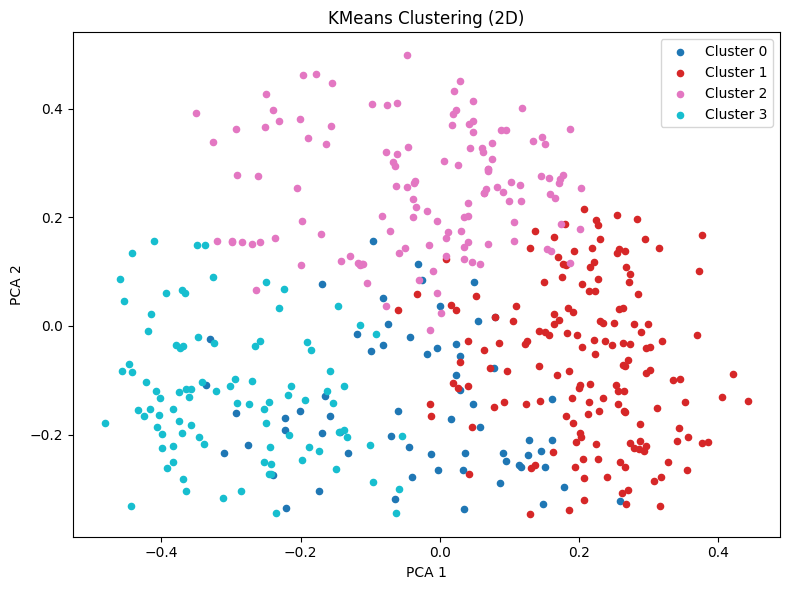

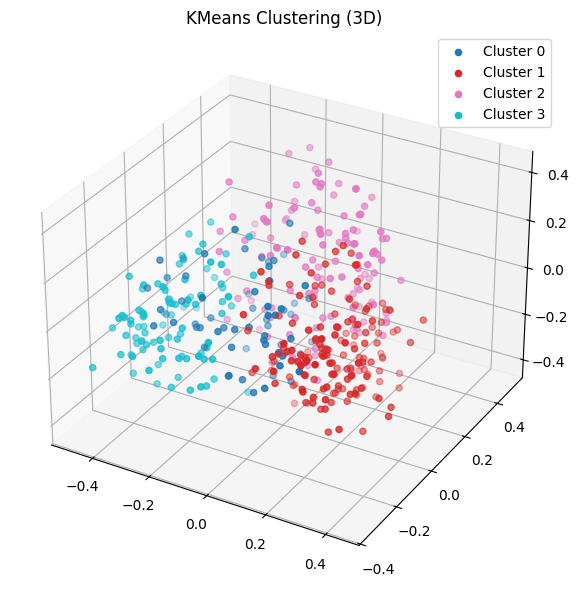

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(abstracts, show_progress_bar=True)

pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)
X_2d = pca_2d.fit_transform(embeddings)
X_3d = pca_3d.fit_transform(embeddings)

plot_clusters(X_2d, best_kmeans["labels"], title="KMeans Clustering (2D)", is_3d=False)
plot_clusters(X_3d, best_kmeans["labels"], title="KMeans Clustering (3D)", is_3d=True)

In [27]:
unique_clusters = df_clusters['Cluster'].unique()
selected_rows = []
for cluster in unique_clusters[:4]:  # Select up to 4 unique clusters
    row = df_clusters[df_clusters['Cluster'] == cluster].iloc[0]
    selected_rows.append(row)
selected_df = pd.DataFrame(selected_rows)

selected_df

,Abstract,Cluster
0,In this chapter we review the body of operatio...,1
1,A crucial step in new product development is t...,3
2,Building Information Modelling (BIM) is define...,2
36,This study sought to identify the drivers of l...,0


In [28]:
cluster_1_abstracts = df_clusters[df_clusters['Cluster'] == 1]['Abstract'].tolist()
cluster_2_abstracts = df_clusters[df_clusters['Cluster'] == 2]['Abstract'].tolist()

In [31]:
cluster_1_abstracts[1]

'Extant literature has shown that sectoral characteristics play a critical role in business value creation through information technology (IT). Therefore, managing IT and its associated risks needs to consider specific industrial traits to understand the distinct business nature and regulations that shape IT-enabled business value creation. This study presents an in-depth analysis of business goals, IT processes, and IT risks in the case of a pharmaceutical company through which appropriate controls are designed to ensure business value creation through IT. Drawing on a case study of a pharmaceutical company in Indonesia, we found that managing IT risks in the pharmaceutical industry entails two main objectives: 1) ensuring compliance with external laws and regulations as well as internal policies, 2) supporting the optimization of business functions, processes, and costs. Throughout one year of engagement during the project, this study identified ten risks associated with the operatio

In [32]:
cluster_2_abstracts[1]

'The proceedings contain 15 papers. The special focus in this conference is on Evaluation of Novel Approaches to Software Engineering. The topics include: Addressing the\xa0Influence of\xa0End User Human Aspects on\xa0Software Engineering; gender Classification Models and\xa0Feature Impact for\xa0Social Media Author Profiling; agile Mindset Adoption in Student Team Projects; ontology-Based Natural Language Processing for\xa0Process Compliance Management; UI-Test: A Model-Based Framework for Visual UI Testing– Qualitative and Quantitative Evaluation; considerations for Indigenous Cultural Aspects in Software Development: A Case Study; modelling Age of End-Users Using Wire-Frames; A Framework for Privacy and Security Requirements Analysis and Conflict Resolution for Supporting GDPR Compliance Through Privacy-by-Design; the Relevance of Privacy Concerns, Trust, and Risk for Hybrid Social Media; From Business Process Textual Description to BPEL Models; xtraLibD: Detecting Irrelevant Third-

In [23]:
selected_df['Abstract'].iloc[0]


'In this chapter we review the body of operations management (OM) literature that studies compliance issues. Researchers in OM focus on how operational-level decisions (such as process improvement, capacity, quality, and risk mitigation) impact performance outcomes in business and society. In recent years there has been growing interest among OM scholars in compliance issues, mostly in the context of environmental regulation and corporate social responsibility (CSR). The focus on operations casts new light and brings novel insights to compliance issues, and in some cases provides guidance for implementable solutions. © 2021 Cambridge University Press.'

In [24]:
selected_df['Abstract'].iloc[1]


'A crucial step in new product development is the design verification process (DVP), which assures that the conceptual design of new technology is successfully transformed into a prototype product. In this paper, a novel DVP for subsea electrical and electronic prototype products is introduced. The comprehensive DVP ensures that the prototype of the product is designed righteously, is well documented, and is verified according to international practices and standards such as The American Petroleum Institute (API), International Organization for Standardization, European Norm, and European Union specifications. Compliance testing [environmental stresses and electromagnetic compatibility (EMC)] on the product is proposed to achieve Technology Readiness Level 2 (TRL2) of the first article of a printed circuit board (PCB). Concerning the quality of an electronic circuit board, it is recommended in this paper to follow the guidelines and specifications of the Institute of Printed Circuits t

In [26]:
selected_df['Abstract'].iloc[2]


'Building Information Modelling (BIM) is defined as the process of creation and management of digital replica for building products in a collaborative design set-up. On this basis, BIM as a digital collaboration platform in AECO (Architecture, Engineering, Construction, and Operation) industry, can be upgraded to assist monitoring, control and improvement of the business processes related to planning, design, construction and operation of building facilities. The main problem in this regard, is the wastage of data related to activities completed by different actors during the project; and subsequently, the lack of analytics to discover latent patterns in collaboration and execution of such processes. The present study aims to enable BIM to capture digital footprints of project actors and create event logs for design authoring phase of building projects. This is done using files in IFC (Industry Foundation Classes) format, archived during the design process. We have developed algorithms

In [25]:
selected_df['Abstract'].iloc[3]


'This study sought to identify the drivers of local government efficiency by investigating three key motivations: internal capacity, rewards for good performance, and compliance with the national government. This paper studied the business registration efficiency cases of 141 highly urbanized and component cities in the Philippines using the cities and municipalities competitiveness index dataset from 2017 to 2019. It was found that capacity-related factors are the most influential in motivating Philippine cities to be more efficient in their business registration processes. Having a higher institutional capacity, higher public service experiences, and good technology infrastructure contribute immensely to better service delivery. Compliance with the national government’s directions on public service standards also positively influences efficiency. In addition, it was confirmed that these factors may appear differently, depending on cities’ size statuses. Other policy implications and 